Generate forward modeled simulated spectra for mock BGS exposures. The forward modeled spectra are generated from GAMA+Legacy simulated source spectra and the re-scaled KS sky model using observational parameters at each exposure. 

In [1]:
import os 
import h5py
import pickle
import numpy as np
# -- astropy --
from astropy import units as u
from astropy.table import Table as aTable
# -- desi -- 
from desispec.io import read_spectra
# -- feasibgs -- 
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import skymodel as Sky
from feasibgs import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
cata = Cat.GamaLegacy()
gleg = cata.Read('g15', dr_gama=3, dr_legacy=7)

redshift = gleg['gama-spec']['z']
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3, galext=False) # ABSMAG k-correct to z=0.1
ngal = len(redshift) # number of galaxies
print('%i galaxies in %s region of GLeg catalog' % (ngal, 'g15'))

r_mag_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])
# r-band magnitude from GAMA (SDSS) photometry
r_mag_gama = gleg['gama-photo']['modelmag_r']
vdisp = np.repeat(100.0, ngal) # velocity dispersions [km/s]

63495 galaxies in g15 region of GLeg catalog


In [4]:
bgs3 = FM.BGStree()
match = bgs3._GamaLegacy(gleg)
hasmatch = (match != -999)
print('%i galaxies do not have matches' % (len(match) - np.sum(hasmatch)))

INFO:io.py:998:read_basis_templates: Reading /Users/ChangHoon/data/desi/spectro/templates/basis_templates/v2.5/bgs_templates_v2.1.fits metadata.
0 galaxies do not have matches


In [5]:
#in_block = (hasmatch & (np.arange(ngal) < 1000))
in_block = (hasmatch & (np.arange(ngal) < 1000))
print np.sum(in_block)

n_block = int(np.ceil(float(ngal) / 1000.))
print('block 1 of %i' % n_block)

1000
block 1 of 64


In [6]:
fblock = ''.join([UT.dat_dir(), 'spectra/gamadr3_legacydr7/g15.source_spectra.mockexp_block.1of', str(n_block), '.p'])
if os.path.isfile(fblock): 
    flux_eml, wave, magnorm_flag = pickle.load(open(fblock, 'rb'))
else: 
    s_bgs = FM.BGSsourceSpectra(wavemin=1500.0, wavemax=2e4)
    emline_flux = s_bgs.EmissionLineFlux(gleg, index=np.arange(ngal)[in_block],
                                         dr_gama=3, silent=True)
    print('---- emission line flux constructed ----')
    flux_eml, wave, _, magnorm_flag = s_bgs.Spectra(r_mag_apflux[in_block], redshift[in_block],
                                                    vdisp[in_block], seed=1, templateid=match[in_block],
                                                    emflux=emline_flux, mag_em=r_mag_gama[in_block], silent=False)
    pickle.dump([flux_eml, wave, magnorm_flag], open(fblock, 'wb'))

In [7]:
# output catalog block
cata_block = cata.select(index=in_block)
cata_block['forwardmodel'] = {}
cata_block['forwardmodel']['magnorm_flag'] = magnorm_flag

fblock = ''.join([UT.dat_dir(), 'spectra/gamadr3_legacydr7/g15.mockexp_block.1of', str(n_block), '.hdf5'])
if not os.path.isfile(fblock):
    cata.write(cata_block, fblock)

In [8]:
# read exposures from file
fexp = h5py.File(''.join([UT.dat_dir(), 'bgs_survey_exposures.withsun.hdf5']), 'r')
exps = {} 
for k in fexp.keys(): 
    exps[k] = fexp[k].value

In [9]:
# read in sky surface brightness using KS model
w_ks, exps_ks = pickle.load(open(''.join([UT.dat_dir(), 'KSsky_brightness.bgs_survey_exposures.withsun.p']), 'rb'))

In [10]:
# read in sky surface brightness using new KS + twilight model
w_new, exps_new = pickle.load(open(''.join([UT.dat_dir(), 'newKSsky_twi_brightness.bgs_survey_exposures.withsun.p']), 'rb'))

In [11]:
specsim_sky = Sky.specsim_initialize('desi')
specsim_wave = specsim_sky._wavelength # Ang
u_surface_brightness = specsim_sky.surface_brightness.unit

/anaconda2/lib/python2.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


In [28]:
fdesi = FM.fakeDESIspec()
def simSpectra_mockexp_KS(i_exp, texp=480): 
    f_simspec = ''.join([UT.dat_dir(), 'spectra/gamadr3_legacydr7/',
                         'g15.sim_spectra.mockexp_block.1of', str(n_block), '.', str(int(texp)), '.iexp', str(i_exp), '.KSsky.fits'])
    if os.path.isfile(f_simspec): 
        bgs_spectra = read_spectra(f_simspec)
    else: 
        bgs_spectra = fdesi.simExposure(wave, flux_eml, exptime=texp, 
                                        airmass=exps['AIRMASS'][i_exp],
                                        skycondition={'name': 'input', 
                                                      'sky': np.clip(exps_ks[i_exp,:], 0, None) * u_surface_brightness, 
                                                      'wave': specsim_wave}, 
                                        filename=f_simspec)
    return bgs_spectra

In [29]:
def simSpectra_mockexp_newKS(i_exp, texp=480): 
    f_simspec = ''.join([UT.dat_dir(), 'spectra/gamadr3_legacydr7/',
                         'g15.sim_spectra.mockexp_block.1of', str(n_block), '.', str(int(texp)), '.iexp', str(i_exp), '.newKSsky.fits'])
    if os.path.isfile(f_simspec): 
        bgs_spectra = read_spectra(f_simspec)
    else: 
        bgs_spectra = fdesi.simExposure(wave, flux_eml, exptime=texp, 
                                        airmass=exps['AIRMASS'][i_exp],
                                        skycondition={'name': 'input', 
                                                      'sky': np.clip(exps_new[i_exp,:], 0, None) * u_surface_brightness, 
                                                      'wave': specsim_wave}, 
                                        filename=f_simspec)
        #pickle.dump(bgs_spectra, open(f_simspec, 'wb'))
    return bgs_spectra

In [14]:
def get_simSpectra_SNR(simspec, i_spec): 
    snrs = [] 
    for band in ['b', 'r', 'z']: 
        these = ((simspec.wave[band] > np.mean(simspec.wave[band])-50) &
                 (simspec.wave[band] < np.mean(simspec.wave[band])+50) &
                 (simspec.flux[band][i_spec] > 0))
        snrs.append(np.median(simspec.flux[band][i_spec, these] * np.sqrt(simspec.ivar[band][i_spec, these])))
    return snrs

(0.0, 20.0)

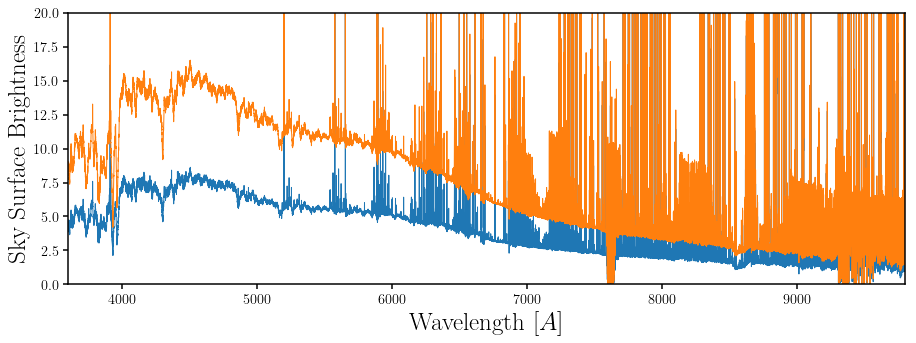

In [15]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(w_ks, exps_ks[0,:], lw=1, label='KS')
sub.plot(w_ks, exps_new[0,:], lw=1, label='new KS')
sub.set_xlabel('Wavelength [$A$]', fontsize=25)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('Sky Surface Brightness', fontsize=25)
sub.set_ylim([0., 20.])

In [16]:
import time 
t0 = time.time() 
simspec_ks0 = simSpectra_mockexp_KS(0, texp=480)
print('took %f mins' % ((time.time() - t0)/60.))
t0 = time.time() 
simspec_newks0 = simSpectra_mockexp_newKS(0, texp=480)
print('took %f mins' % ((time.time() - t0)/60.))

took 0.036743 mins
took 0.032919 mins


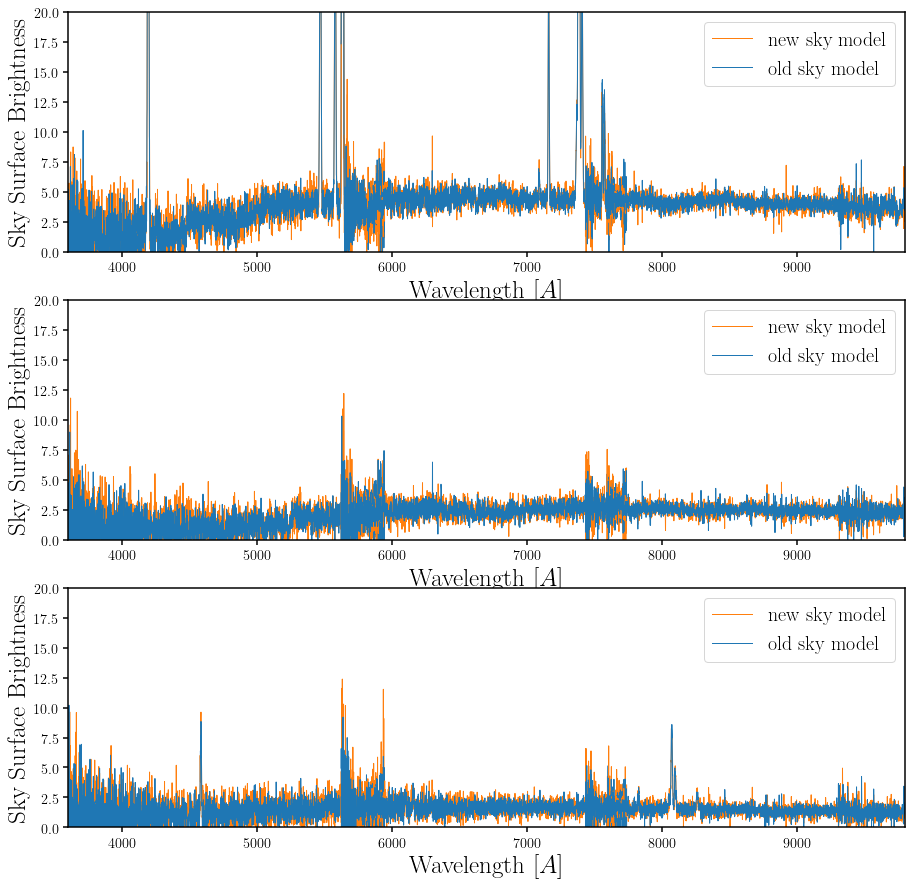

In [17]:
fig = plt.figure(figsize=(15,15))
for i_spec in range(3): 
    sub = fig.add_subplot(3,1,i_spec+1)
    for band in ['b', 'r', 'z']: 
        sub.plot(simspec_newks0.wave[band], simspec_newks0.flux[band][i_spec], lw=1, c='C1', label='new sky model')
        sub.plot(simspec_ks0.wave[band], simspec_ks0.flux[band][i_spec], lw=1, c='C0', label='old sky model')
        if band == 'b': sub.legend(loc='upper right', frameon=True, fontsize=20)
    sub.set_xlabel('Wavelength [$A$]', fontsize=25)
    sub.set_xlim([3600., 9800.])
    sub.set_ylabel('Sky Surface Brightness', fontsize=25)
    sub.set_ylim([0., 20.])

In [18]:
snr_ks0 = np.zeros((3, np.sum(magnorm_flag)))
snr_newks0 = np.zeros((3, np.sum(magnorm_flag)))

i_specs = np.arange(len(magnorm_flag))[magnorm_flag]
for ii, i_spec in enumerate(i_specs): 
    ks0 = get_simSpectra_SNR(simspec_ks0, i_spec)
    snr_ks0[:,ii] = np.array(ks0)
    newks0 = get_simSpectra_SNR(simspec_newks0, i_spec)
    snr_newks0[:,ii] = np.array(newks0)

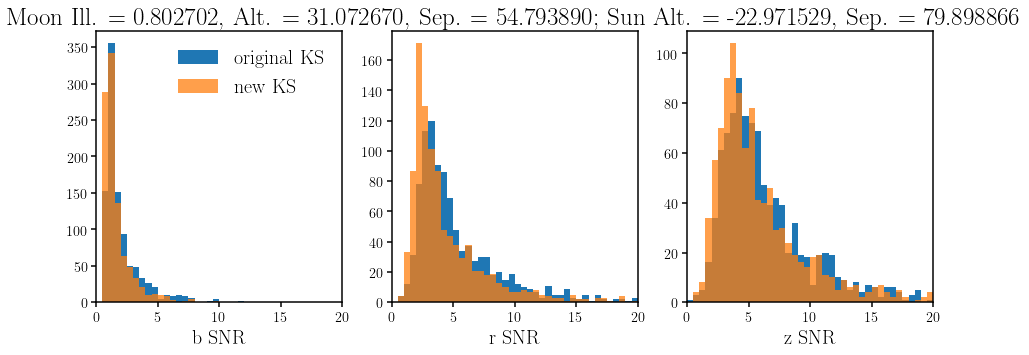

In [19]:
fig = plt.figure(figsize=(15,5))
for i, band in enumerate(['b', 'r', 'z']): 
    sub = fig.add_subplot(1,3,1+i)
    sub.hist(snr_ks0[i,:], range=(0, 20), bins=40, color='C0', label='original KS')
    sub.hist(snr_newks0[i,:], range=(0, 20), bins=40, color='C1', alpha=0.75, label='new KS')
    sub.set_xlabel(band+' SNR', fontsize=20)
    sub.set_xlim([0., 20.])
    if i == 0: sub.legend(loc='upper right', fontsize=20)
    if i == 1: sub.set_title(("Moon Ill. = %f, Alt. = %f, Sep. = %f; Sun Alt. = %f, Sep. = %f" % 
                              (exps['MOONFRAC'][0], exps['MOONALT'][0], exps['MOONSEP'][0], exps['SUNALT'][0], exps['SUNSEP'][0])), 
                             fontsize=25)

### Exposure with sun above altitutde > -20

In [20]:
simspec_ks3600 = simSpectra_mockexp_KS(3600, texp=480)
simspec_newks3600 = simSpectra_mockexp_newKS(3600, texp=480)

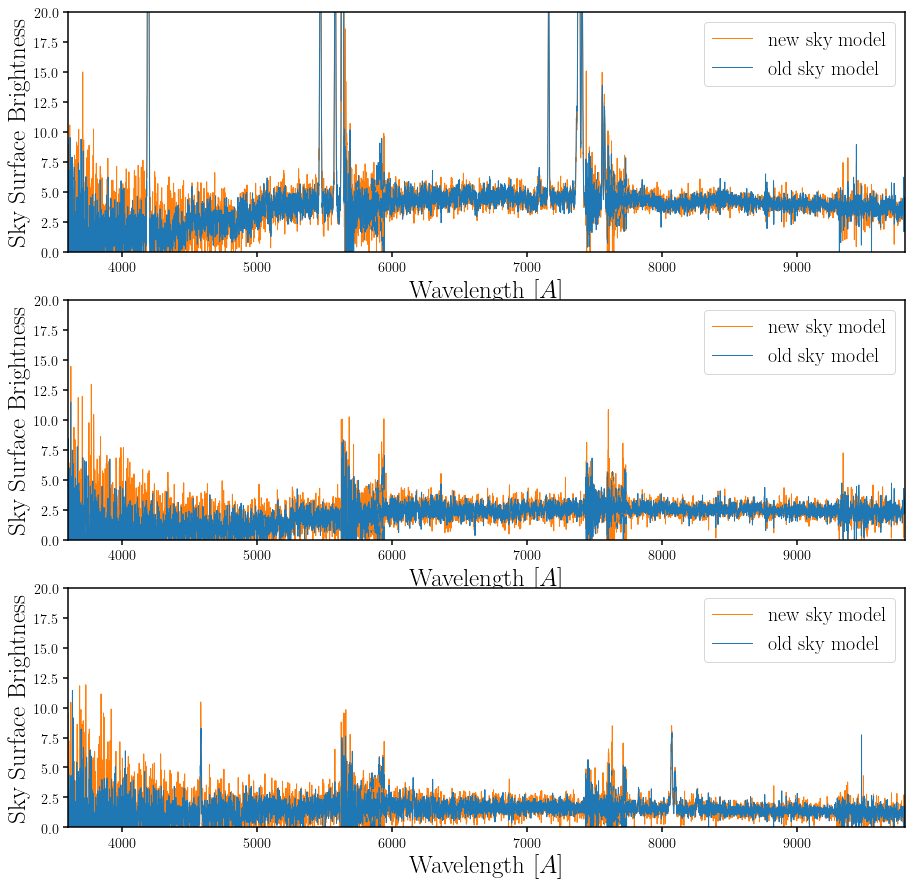

In [21]:
fig = plt.figure(figsize=(15,15))
for i_spec in range(3): 
    sub = fig.add_subplot(3,1,i_spec+1)
    for band in ['b', 'r', 'z']: 
        sub.plot(simspec_newks3600.wave[band], simspec_newks3600.flux[band][i_spec], lw=1, c='C1', label='new sky model')
        sub.plot(simspec_ks3600.wave[band], simspec_ks3600.flux[band][i_spec], lw=1, c='C0', label='old sky model')
        if band == 'b': sub.legend(loc='upper right', frameon=True, fontsize=20)
    sub.set_xlabel('Wavelength [$A$]', fontsize=25)
    sub.set_xlim([3600., 9800.])
    sub.set_ylabel('Sky Surface Brightness', fontsize=25)
    sub.set_ylim([0., 20.])

In [22]:
snr_ks3600 = np.zeros((3, np.sum(magnorm_flag)))
snr_newks3600 = np.zeros((3, np.sum(magnorm_flag)))

i_specs = np.arange(len(magnorm_flag))[magnorm_flag]
for ii, i_spec in enumerate(i_specs): 
    ks3600 = get_simSpectra_SNR(simspec_ks3600, i_spec)
    snr_ks3600[:,ii] = np.array(ks3600)
    newks3600 = get_simSpectra_SNR(simspec_newks3600, i_spec)
    snr_newks3600[:,ii] = np.array(newks3600)

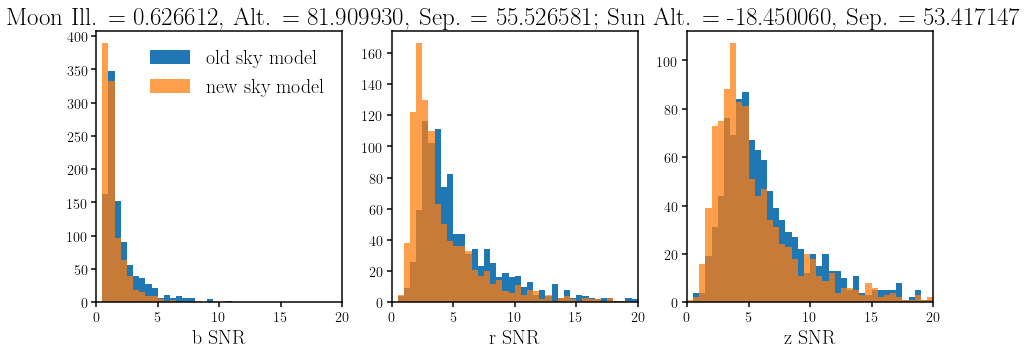

In [23]:
fig = plt.figure(figsize=(15,5))
for i, band in enumerate(['b', 'r', 'z']): 
    sub = fig.add_subplot(1,3,1+i)
    sub.hist(snr_ks3600[i,:], range=(0, 20), bins=40, color='C0', label='old sky model')
    sub.hist(snr_newks3600[i,:], range=(0, 20), bins=40, color='C1', alpha=0.75, label='new sky model')
    sub.set_xlabel(band+' SNR', fontsize=20)
    sub.set_xlim([0., 20.])
    if i == 0: sub.legend(loc='upper right', fontsize=20)
    if i == 1: sub.set_title(("Moon Ill. = %f, Alt. = %f, Sep. = %f; Sun Alt. = %f, Sep. = %f" % 
                              (exps['MOONFRAC'][3600], exps['MOONALT'][3600], exps['MOONSEP'][3600], exps['SUNALT'][3600], exps['SUNSEP'][3600])), 
                             fontsize=25)

In [24]:
_ = simSpectra_mockexp_KS(22, texp=480)
_ = simSpectra_mockexp_newKS(22, texp=480)

In [30]:
_ = simSpectra_mockexp_KS(2268, texp=480)
_ = simSpectra_mockexp_newKS(2268, texp=480)

In [22]:
#for i_exp in range(len(exps))[::100]: 
#    simspec_ks_i = simSpectra_mockexp_KS(i_exp,gi texp=480)
#    simspec_newks_i = simSpectra_mockexp_newKS(i_exp, texp=480)

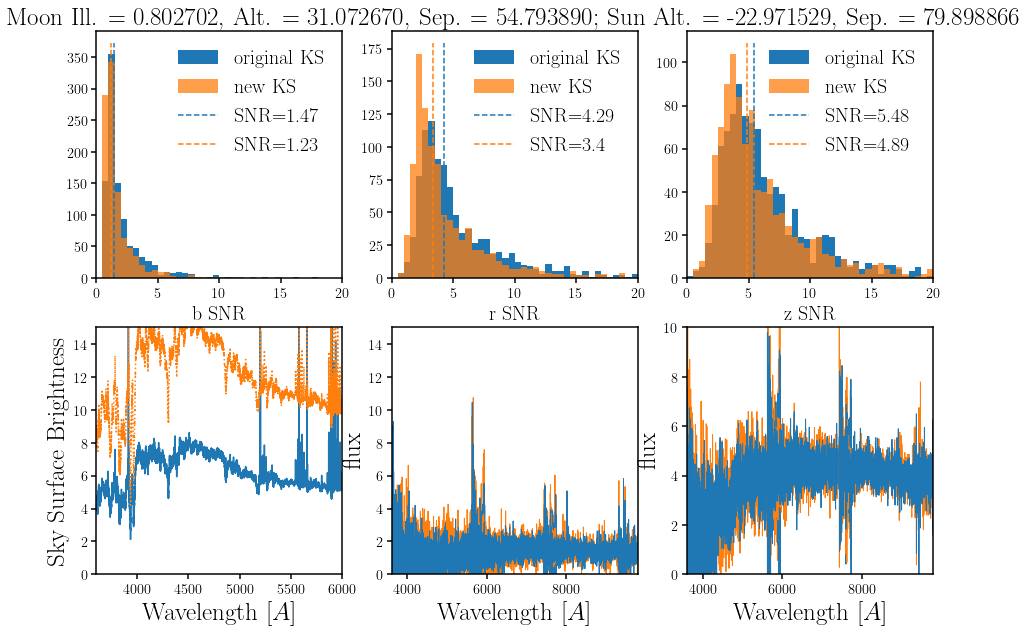

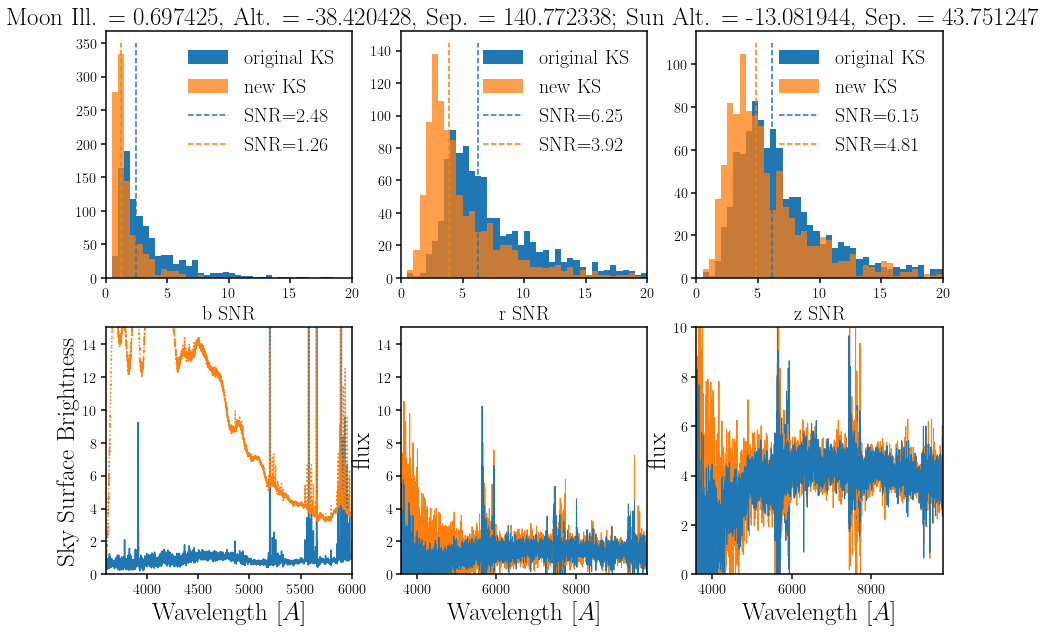

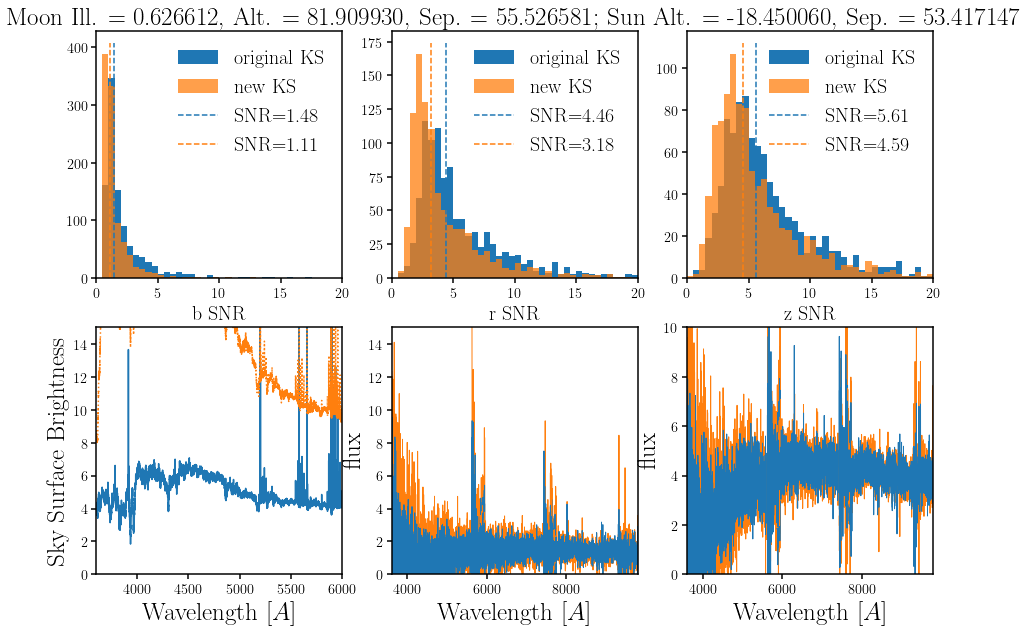

In [32]:
i_sub = np.arange(len(exps))[::100]
for i in [0, 2268, 3600]: #i_sub[:3]: #np.random.choice(i_sub, 3, replace=False): 
    simspec_ks1 = simSpectra_mockexp_KS(i, texp=480)
    simspec_newks1 = simSpectra_mockexp_newKS(i, texp=480)

    snr_ks1 = np.zeros((3, np.sum(magnorm_flag)))
    snr_newks1 = np.zeros((3, np.sum(magnorm_flag)))

    i_specs = np.arange(len(magnorm_flag))[magnorm_flag]
    for ii, i_spec in enumerate(i_specs): 
        ks1 = get_simSpectra_SNR(simspec_ks1, i_spec)
        snr_ks1[:,ii] = np.array(ks1)
        newks1 = get_simSpectra_SNR(simspec_newks1, i_spec)
        snr_newks1[:,ii] = np.array(newks1)
    
    fig = plt.figure(figsize=(15,10))
    for ii, band in enumerate(['b', 'r', 'z']): 
        sub = fig.add_subplot(2,3,1+ii)
        sub.hist(snr_ks1[ii,:], range=(0, 20), bins=40, color='C0', label='original KS')
        sub.hist(snr_newks1[ii,:], range=(0, 20), bins=40, color='C1', alpha=0.75, label='new KS')
        #sub.plot([0., 0.], [0., 0.], c='k', ls='--', label='Median SNR')
        sub.set_xlabel(band+' SNR', fontsize=20)
        sub.set_xlim([0., 20.])
        ymin, ymax = sub.get_ylim()
        sub.vlines(np.median(snr_ks1[ii,:]), ymin, ymax, color='C0', linestyle='--', 
                   label='SNR='+str(round(np.median(snr_ks1[ii,:]),2)))
        sub.vlines(np.median(snr_newks1[ii,:]), ymin, ymax, color='C1', linestyle='--', 
                   label='SNR='+str(round(np.median(snr_newks1[ii,:]),2)))
        sub.legend(loc='upper right', fontsize=20)
        if ii == 1: 
            sub.set_title(("Moon Ill. = %f, Alt. = %f, Sep. = %f; Sun Alt. = %f, Sep. = %f" % 
                           (exps['MOONFRAC'][i], exps['MOONALT'][i], exps['MOONSEP'][i], exps['SUNALT'][i], exps['SUNSEP'][i])), 
                          fontsize=25)
    sub = fig.add_subplot(234)
    sub.plot(specsim_wave, exps_ks[i,:], c='C0')
    sub.plot(specsim_wave, exps_new[i,:], ls=':', c='C1')
    sub.set_xlabel('Wavelength [$A$]', fontsize=25)
    sub.set_xlim([3600., 6000.])
    sub.set_ylabel('Sky Surface Brightness', fontsize=25)
    sub.set_ylim([0., 15.])
    
    sub = fig.add_subplot(235)
    for band in ['b', 'r', 'z']: 
        sub.plot(simspec_newks1.wave[band], simspec_newks1.flux[band][10], lw=1, c='C1', label='new KS')
        sub.plot(simspec_ks1.wave[band], simspec_ks1.flux[band][10], lw=1, c='C0', label='KS')
    sub.set_xlabel('Wavelength [$A$]', fontsize=25)
    sub.set_xlim([3600., 9800.])
    sub.set_ylabel('flux', fontsize=25)
    sub.set_ylim([0., 15.])
    
    sub = fig.add_subplot(236)
    for band in ['b', 'r', 'z']: 
        sub.plot(simspec_newks1.wave[band], simspec_newks1.flux[band][100], lw=1, c='C1', label='new KS')
        sub.plot(simspec_ks1.wave[band], simspec_ks1.flux[band][100], lw=1, c='C0', label='KS')
    sub.set_xlabel('Wavelength [$A$]', fontsize=25)
    sub.set_xlim([3600., 9800.])
    sub.set_ylabel('flux', fontsize=25)
    sub.set_ylim([0., 10.])